In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: ter Veen, Dylan (0951715)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

My idea was to have layers that alternate with having larger and smaller output values. The relu and sigmoid activations functions allow for this. This might keep the more probabilistic important features and then zooms in on these again in the next two-layer alternation. The performance seems reasonable, the validation loss and accuracy is somewhat equal to the training loss and accuracy, apart from the end. (length: 413)



Max val score: 74.48%


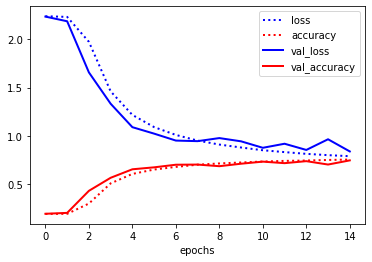

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 768)               2360064   
_________________________________________________________________
dense_25 (Dense)             (None, 192)               147648    
_________________________________________________________________
dense_26 (Dense)             (None, 48)                9264      
_________________________________________________________________
dense_27 (Dense)             (None, 10)                490       
Total params: 2,517,466
Trainable params: 2,517,466
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_1():
    model = models.Sequential()
    # Convert to input layer
    model.add(layers.

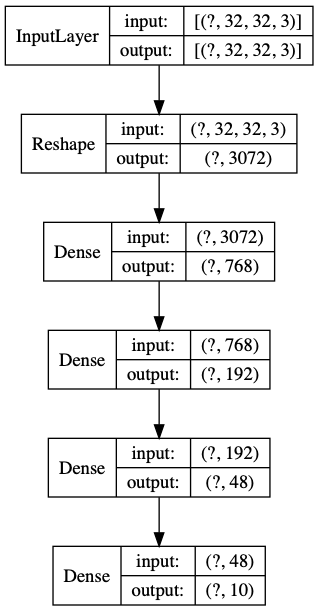

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

Therefore, I changed the size of the network to a third, since it should stay the same with respect to question 1_1. I did change the size of the first layer to twice its original size afterwards, since the amount of information is less in the input, I thought, and based on experimentation, that making the first layer bigger would help with this. Initially, the network was a bit worse, but after changing the first layer size to twice its original, it became a tiny bit better, even though there is a bit more overfitting happening, and it is more irregular, the validation set accuracy is still a bit higher. (length: 613)



Max val score: 75.72%


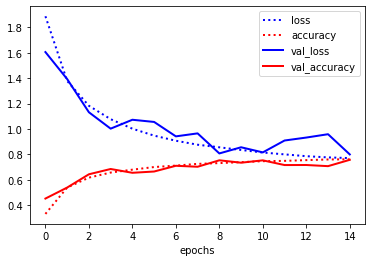

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_29 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_30 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_31 (Dense)             (None, 10)                330       
Total params: 594,922
Trainable params: 594,922
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_2():
    model = models.Sequential()
    # Convert to input layer
    model.add(layers.Resh

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

I thought that this would be a better alternative than the sigmoid layers. I also added the L2 normalization to the relu layers to ensure lower weights. After some experimentation, the sizes of the regular relu layers appeared to be best as they were. The batch size was better when it would be 64 than 32 or 128, so I decided to leave it at 64. The performance of the model is a lot better. The training is has a worse accuracy than the test data. The goal of this part was to limit the overfitting by using the batchnormalization layers and the regularization in the layers, and this seems to really work out. (length: 612)



Max val score: 80.61%


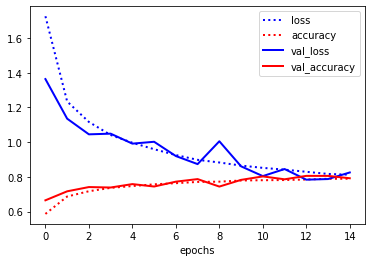

def build_model_1_3():
    model = models.Sequential()
    # Convert to input layer
    model.add(layers.Reshape((1024,), input_shape=(32, 32, 1)))
    # Hidden layers
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    # Output layer
    model.add(layers.Dense(10, activation='softmax'))
    # Make the model
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

Therefore, I remained at two. I did experiment with more than two convoluting layers, but this also turned out to be worse. After these layers, using the same network as before would be a logical choice, so I believe since this was already partly discovered in previous questions. Even though we see a lot of overfitting, the validation accuracy is about 90 percent, but because the training accurcacy is a lot more, I believe this can be useful when we have more training data. Also, when using normalization in the layers, the performance went down, so I let them go in this solution. (length: 587)



Max val score: 90.86%


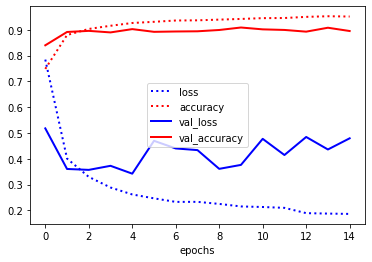

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_111 (Dense)            (None, 512)               2359808   
_________________________________________________________________
dense_112 (Dense)            (None, 128)             

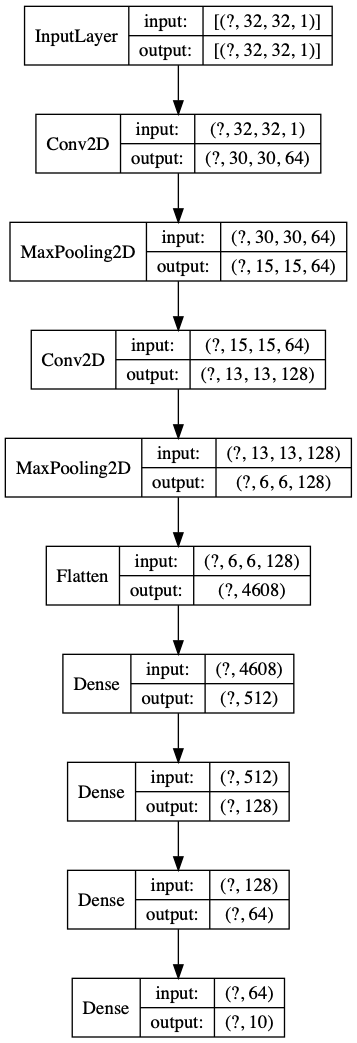

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

rotation because an image could be rotated slightly, which a person often does. changing the positioning of the image, since a number might be more to the side on one image than another. shear change since the angle of the picture can change, when an image is not taken orthogonal to the surface. zoom since an image can be closer to the digits than on other images. After a lot of experimentation, I got the same results as before, but without the overfitting. I found it quite strange that shifting and zooming influenced the model negatively, so I only kept the rotation and shearing of the images. Now, there is no more overfittng and the model is equally good. (length: 666)



Max val score: 90.85%


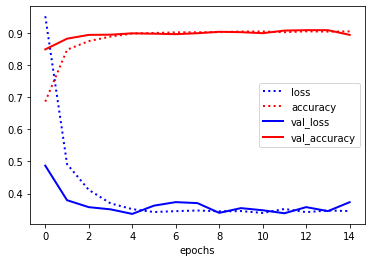


    train_datagen = ImageDataGenerator(
      rotation_range=20,
      # width_shift_range=0.4,
      # height_shift_range=0.3,
      shear_range=0.2,
      # zoom_range=0.2,
      fill_mode='nearest'
      )


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

The validation accuracy for model 2_2 is 0.91. Also, I wanted to look at how the data was distributed, which may explain difficulties in categorization of classes. TRhe confusion matrix shows that the diagonal most classifications are correct (the diagonal). The most often confused class seems to be when the true = 8, so we analyse this class. I print the output of the network for both correct and incorrect classifications. From this, we can see that the network is actually never very sure that something is classified even correctly. In quite some cases it is even very unsure it would be classified as 8. So, to me it would suggest that the network is either not trained enough or too big still. I have no idea how to solve this, as this result occured with many different solutions. (length: 791)

Test score: 0.91%


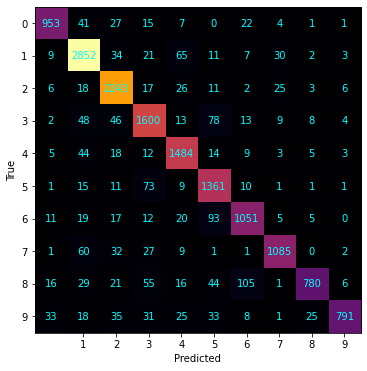

Correct:  [[5.3284306e-04 2.2582628e-04 2.5769850e-02 5.5679120e-04 1.1132575e-02
  1.9812991e-01 1.9938630e-05 7.6314020e-01 2.4168499e-04 2.5045796e-04]]
Correct:  [[6.1862258e-09 6.6862321e-11 5.2613817e-08 9.4205782e-11 8.6915974e-11
  9.8561763e-08 4.6655301e-13 9.9999928e-01 5.5347675e-07 2.2873162e-10]]
Correct:  [[0.01515306 0.17449354 0.13559812 0.05105129 0.00814765 0.02130815
  0.00532952 0.5554708  0.02855596 0.00489182]]
Correct:  [[2.93240696e-03 1.61357864e-03 3.99189349e-03 1.22588752e-02
  1.07175310e-03 1.45544723e-01 4.36486298e-05 7.61366963e-01
  1.41777545e-02 5.69984652e-02]]
Correct:  [[6.4207217e-09 1.7070581e-10 7.8000835e-07 1.2685907e-09 1.9472696e-10
  9.0208567e-07 4.5034345e-12 9.9999797e-01 2.5027376e-07 7.9119117e-10]]
Correct:  [[0.0082898  0.01050904 0.03682376 0.03496572 0.06754503 0.2981686
  0.00267207 0.51972944 0.01252169 0.00877475]]


Incorrect:  [[0.02004722 0.01256392 0.42601362 0.00670601 0.28646353 0.02883062
  0.00287654 0.17961228 0.03471413 0.00217204]]
Correct:  [[2.8281988e-04 1.7861696e-05 8.3688466e-04 2.3678716e-04 1.3888042e-04
  3.1645518e-02 1.3932602e-06 9.6641415e-01 1.5380213e-04 2.7183507e-04]]
Correct:  [[1.1512715e-03 6.8474089e-04 1.7176422e-03 1.2458476e-03 3.9235433e-04
  8.7223202e-02 3.1000742e-05 9.0209621e-01 6.7834329e-04 4.7794213e-03]]
Correct:  [[1.0440006e-06 1.8803967e-06 4.2807671e-05 3.3158258e-07 6.1942472e-07
  2.1891310e-05 9.7640900e-09 9.9986160e-01 6.9770838e-05 7.4225518e-08]]
Correct:  [[1.8337270e-04 2.7405829e-04 2.0609293e-03 1.6949356e-04 5.0483871e-04
  7.4215429e-03 7.0029569e-06 9.8623371e-01 2.9473656e-03 1.9772218e-04]]
Incorrect:  [[0.05538884 0.02435469 0.02478476 0.08763611 0.01617778 0.21861099
  0.00513374 0.10304411 0.02216644 0.44270247]]


Incorrect:  [[0.02475896 0.23523018 0.02785286 0.00573256 0.15486206 0.01416107
  0.02064365 0.04220386 0.47375134 0.00080342]]
Incorrect:  [[1.9936798e-04 6.8634813e-06 2.1524287e-05 1.3579006e-03 7.0075941e-04
  9.4711310e-01 3.1327181e-07 4.9100187e-02 9.0702342e-05 1.4091950e-03]]
Incorrect:  [[0.2569581  0.01531503 0.03739249 0.01498409 0.02963301 0.12013061
  0.01095579 0.20026664 0.03330753 0.28105673]]


Incorrect:  [[0.01586773 0.00851189 0.01669263 0.0033493  0.00520635 0.12728408
  0.00099363 0.2638595  0.0088103  0.5494246 ]]
Incorrect:  [[2.1335753e-03 1.3199791e-02 3.4058359e-03 1.3747121e-02 1.6619114e-02
  9.0536618e-01 5.9404358e-04 3.0709408e-02 8.7615539e-04 1.3348753e-02]]
Incorrect:  [[0.02075523 0.1540786  0.0493294  0.03156931 0.12588692 0.2795183
  0.0096808  0.06430034 0.07233426 0.19254693]]


Incorrect:  [[0.01593975 0.0640071  0.28340393 0.04019618 0.32754493 0.09006888
  0.01481322 0.11541721 0.03943351 0.00917516]]
Incorrect:  [[0.02083147 0.01604247 0.02072109 0.08455548 0.04516613 0.06293979
  0.00116113 0.3462091  0.38288137 0.01949196]]
Correctly classified


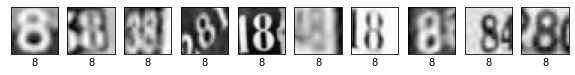

Incorrectly classified


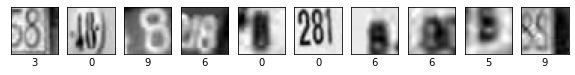

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

filters in the network. I did do this, and it turned out with the two convoluting layers at half the number of filters the network performed about the same. I did not include this network since I liked how this made me realise that it could be smaller. The first layer looks a lot at lighting in my opinion. I cannot make a lot of sense of the activations of the second convoluting layer, but it seems to me that it looks at thicker lines within the image. This could be because the images are of low dimension, so making a lot of sense of the dots is difficult. (length: 563)



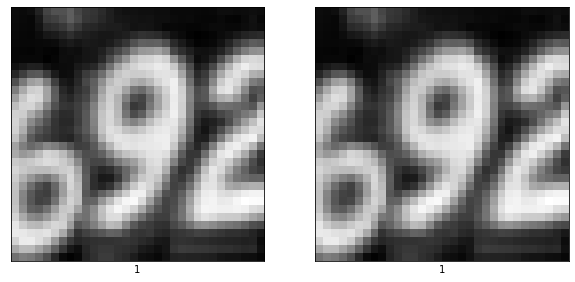

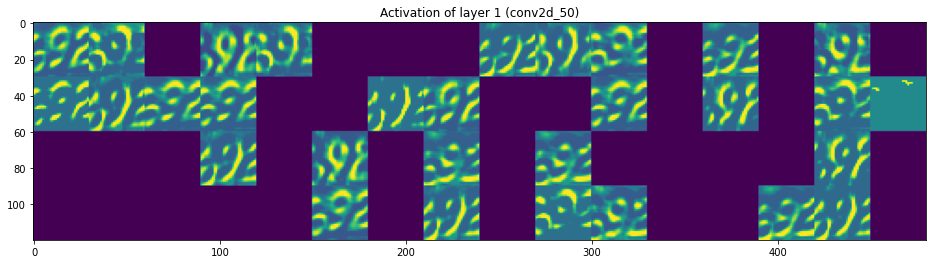

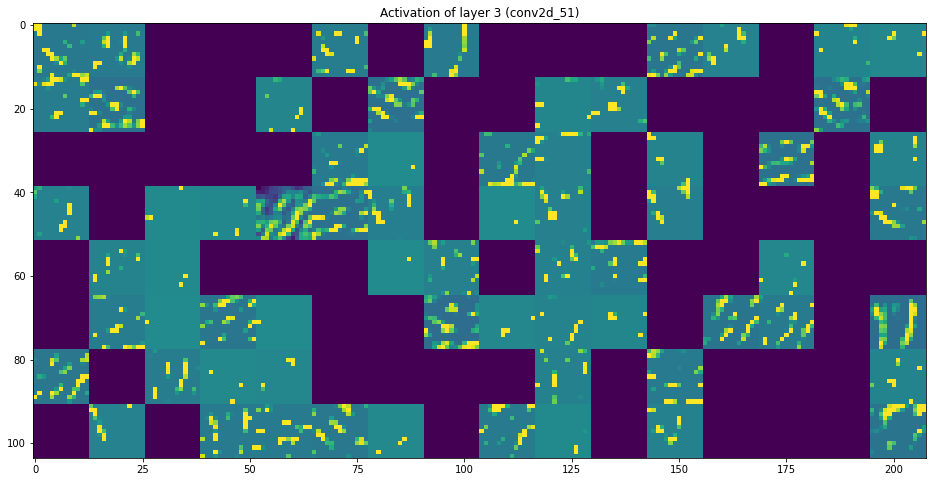

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

def plot_3_3():
    pass



#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

the last convolutional layer was unfrozen. The graph does show very erratic loss function and validation accuracy, and also overfitting. However, my attempts to prevent overfitting and less erratic behaviour did not help, so I left it like this. (length: 246)



Max val score: 83.06%


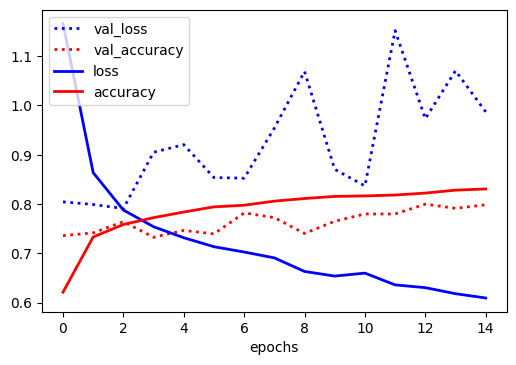

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_34 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 7,213,322
Non-trainable params: 7,635,264
_________________________________________________________________
None
def build_model_4_1():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
    for layer in conv_base.layers[:15]:
        layer.trainable = False

    model = Sequential()
    model.add(conv_bas

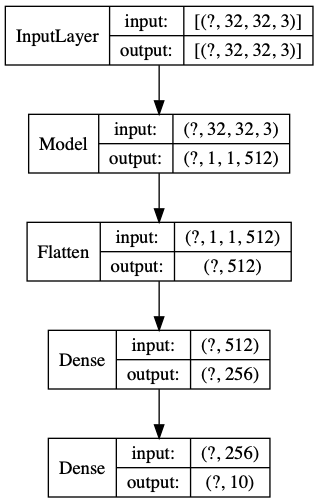

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

Your answer  (length: 13)

None
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    pass

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    pass



In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 33.95 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
